<a href="https://colab.research.google.com/github/Naomy-Yailin/SIS420/blob/main/Laboratorio4/Laboratorio4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contiene los 26 alfabetos ingleses como clases, por lo que es un problema de clasificación multiclase con 26 clases.

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize
import pandas as pd
from sklearn.model_selection import train_test_split
#Se usa para convertir etiquetas categóricas en números enteros.
from sklearn.preprocessing import LabelEncoder



# modulo para cargar archivos en formato MATLAB
# from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

In [21]:
# Cargar dataset Letter Recognition
# (ajusta la ruta si estás en Colab u otra carpeta)
data = pd.read_csv('/content/letter-recognition.csv')

# y = columna de la letra (A–Z), X = 16 características siguientes
y_raw = data.iloc[:, 0]          # 'letter'
X = data.iloc[:, 1:].values      # 16 atributos numéricos

# Codificar etiquetas A–Z a 0–25
le = LabelEncoder()
y = le.fit_transform(y_raw)       # A->0, B->1, ..., Z->25

# Definir número de entradas y salidas
input_layer_size = X.shape[1] + 1   # 16 + 1 (bias) = 17
num_labels = len(le.classes_)        # 26 clases (A–Z)

# Número de ejemplos
m = y.size

print("Número de ejemplos:", m)
print("Dimensión de X:", X.shape)          # (20000, 16) en la versión clásica
print("Clases distintas:", num_labels)     # 26
print("Primeras etiquetas (codificadas):", y[:10])
print("Mapa de clases (índice→letra):", dict(enumerate(le.classes_)))

Número de ejemplos: 20000
Dimensión de X: (20000, 16)
Clases distintas: 26
Primeras etiquetas (codificadas): [19  8  3 13  6 18  1  0  9 12]
Mapa de clases (índice→letra): {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [22]:
print(X[0,:])
print(y)

[ 2  8  3  5  1  8 13  0  6  6 10  8  0  8  0  8]
[19  8  3 ... 19 18  0]


In [23]:
# 4. Definir la función de normalización
def featureNormalize(X):
    X_norm = X.copy().astype(float)     # asegurar que no sea int
    mu = np.mean(X, axis=0)             # medias de cada columna
    sigma = np.std(X, axis=0, ddof=0)   # desviaciones estándar
    X_norm = (X - mu) / sigma           # normalización
    return X_norm, mu, sigma

# 5. Aplicar normalización
X_norm, mu, sigma = featureNormalize(X)

In [24]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X)

In [25]:
print(X_norm[0,:])
print(y)

[-1.0576983   0.29187713 -1.05327668 -0.16470367 -1.14401317  0.54413045
  2.36509711 -1.71435955  0.34499439 -0.91707055  1.34777427  0.03412531
 -1.30594761 -0.21908163 -1.4381527   0.12291107]
[19  8  3 ... 19 18  0]


In [26]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# Agraga el termino de intercepción a A
# X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)
X = X_norm
# X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [27]:
# 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (16000, 16) (16000,)
Test : (4000, 16) (4000,)


In [28]:
def sigmoid(z):
    """
    Calcula la sigmoide de z.
    """
    return 1.0 / (1.0 + np.exp(-z))

In [29]:
def calcularCosto(theta, X, y):
    # Inicializar algunos valores utiles
    m = y.size  # numero de ejemplos de entrenamiento

    J = 0
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))

    return J

In [30]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    m = y.shape[0]
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        h = sigmoid(X.dot(theta))
        theta = theta - (alpha / m) * X.T.dot(h - y)
        J_history.append(calcularCosto(theta, X, y))

    return theta, J_history

In [31]:
def OneVsAll(X, y, num_labels):
    alpha = 0.015
    num_iters = 3000

    m, n = X.shape
    all_theta = np.zeros((num_labels, n+1))

    # Agregar columna de 1’s
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in range(num_labels):
        initial_theta = np.zeros(n+1)
        y_actual = np.where(y == c, 1, 0)

        theta, J_history = descensoGradiente(initial_theta, X, y_actual, alpha, num_iters)
        all_theta[c] = theta

        # Curva de costo por clase
        plt.plot(np.arange(len(J_history)), J_history, lw=2)
        plt.xlabel("Número de iteraciones")
        plt.ylabel("Costo J")
        plt.title(f"Convergencia del costo para clase {c} ({le.classes_[c]})")
        plt.show()

    return all_theta

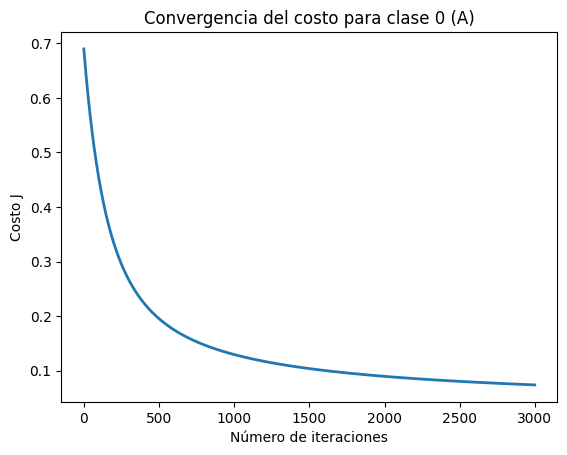

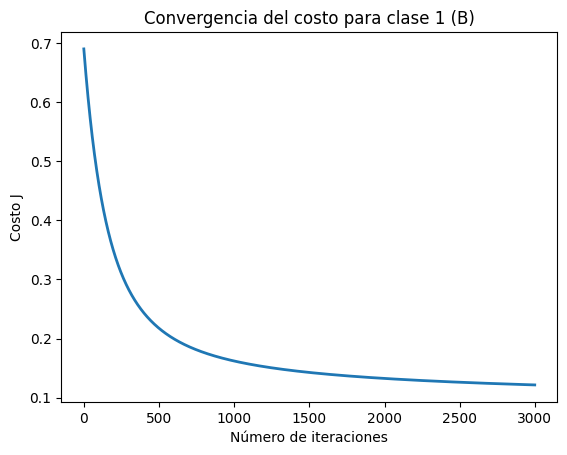

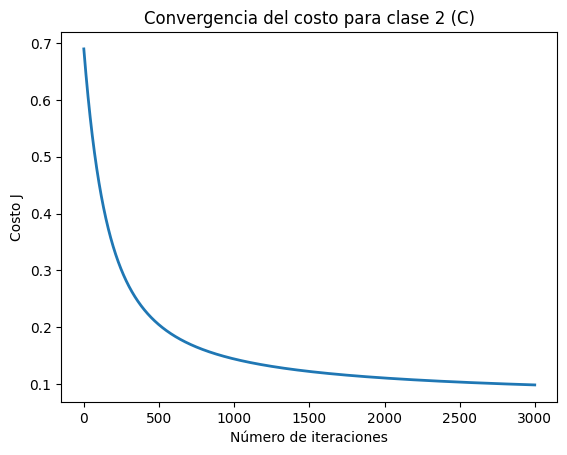

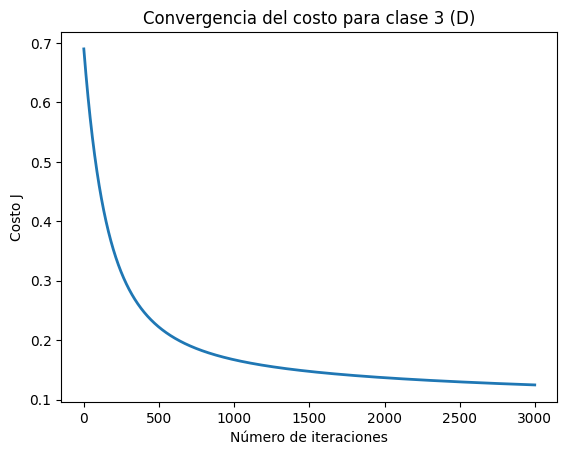

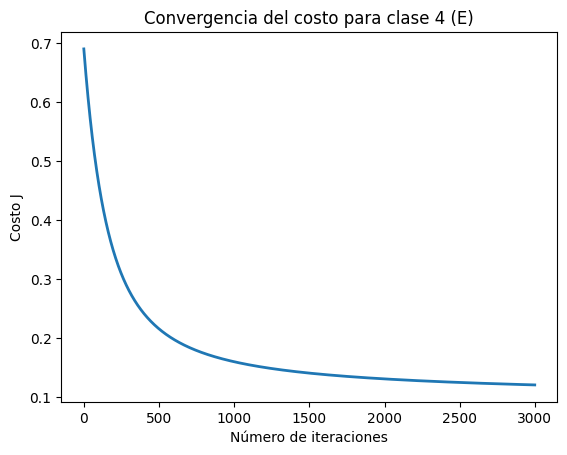

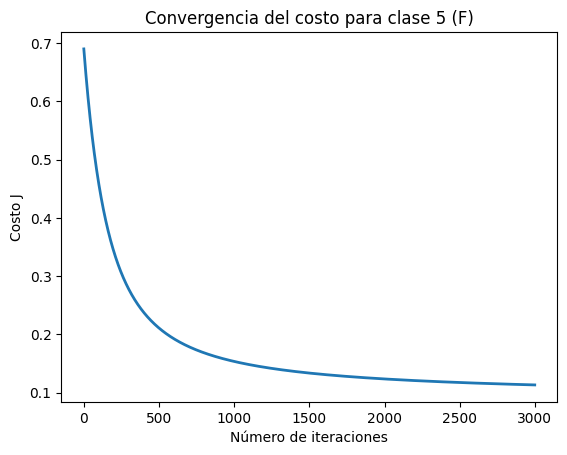

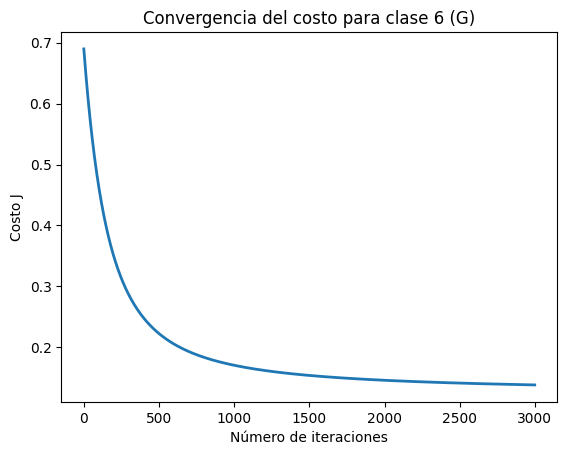

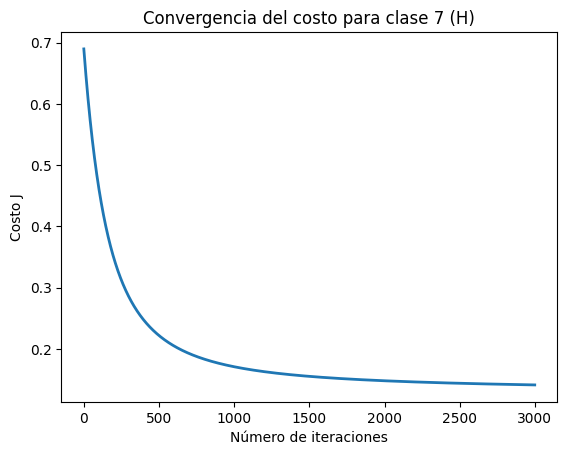

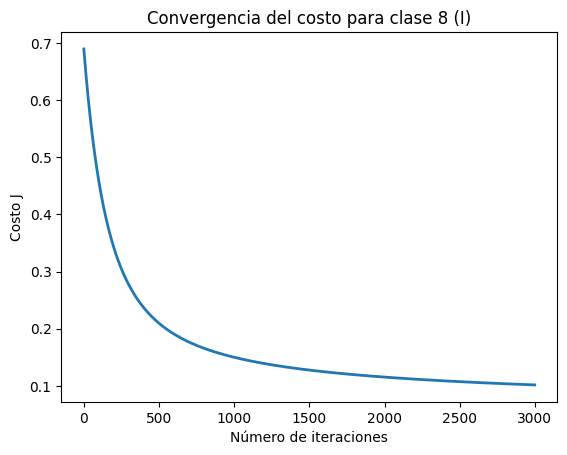

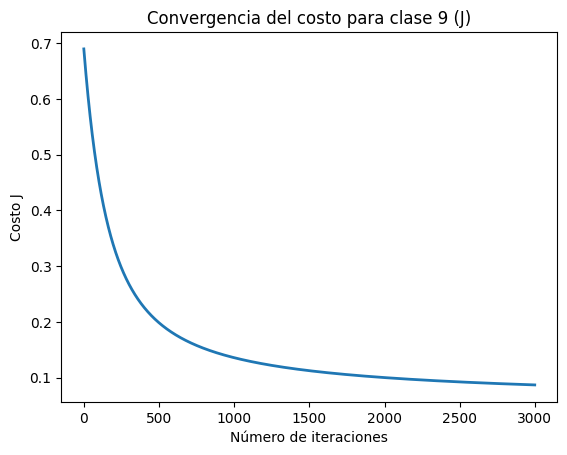

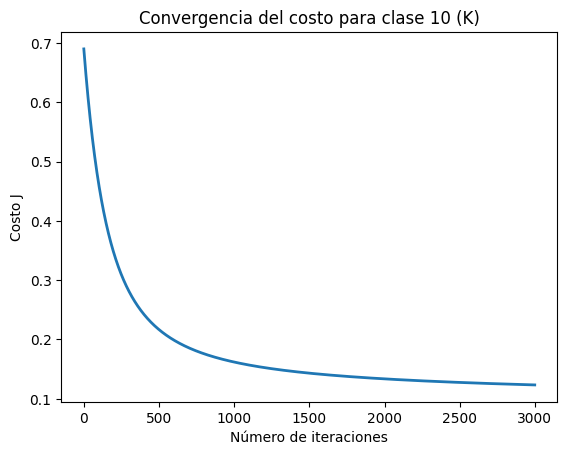

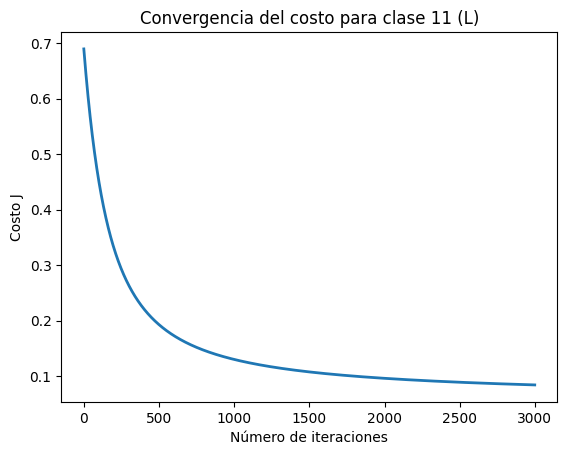

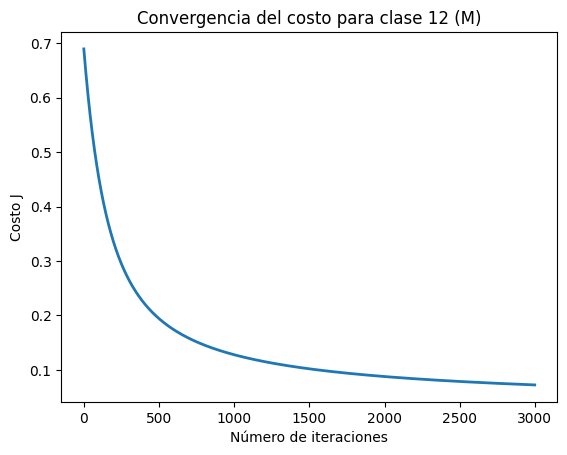

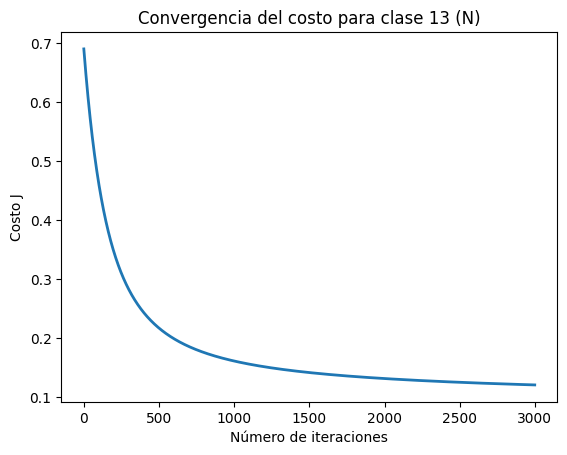

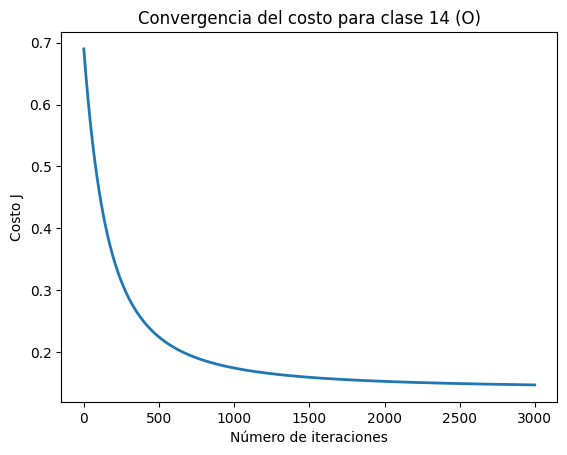

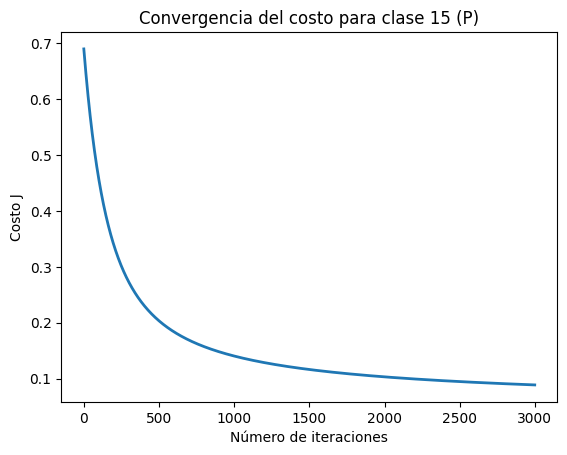

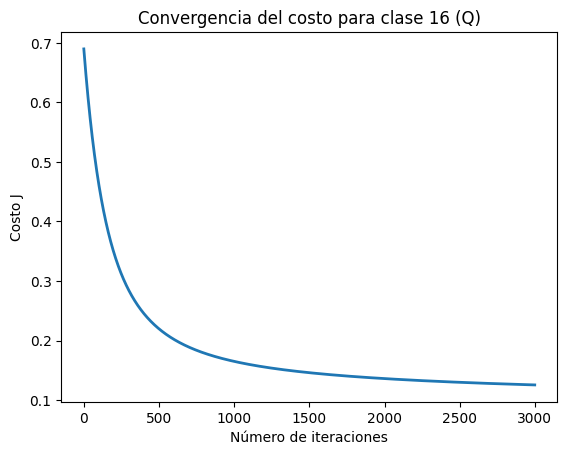

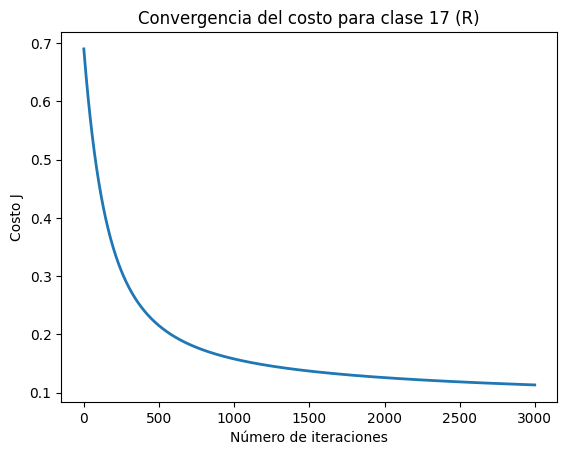

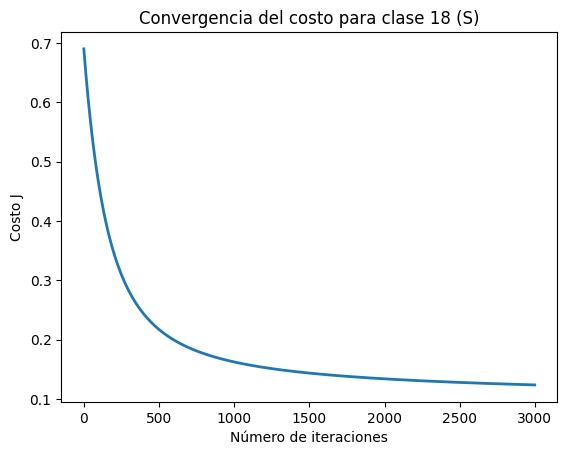

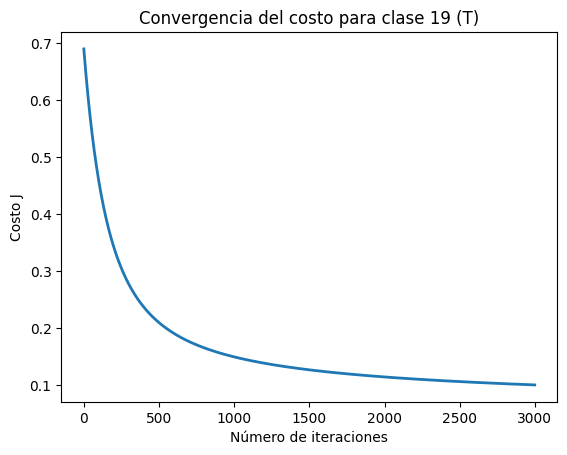

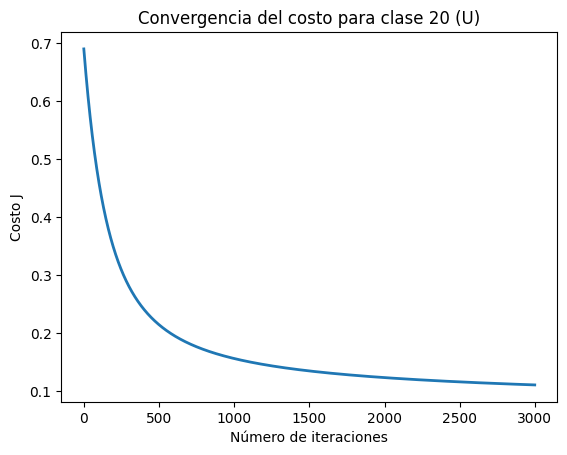

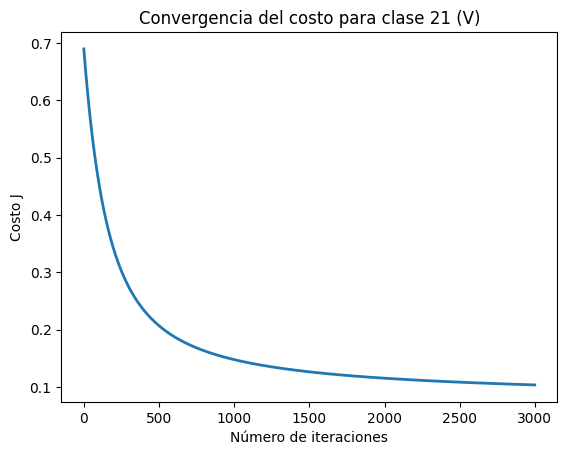

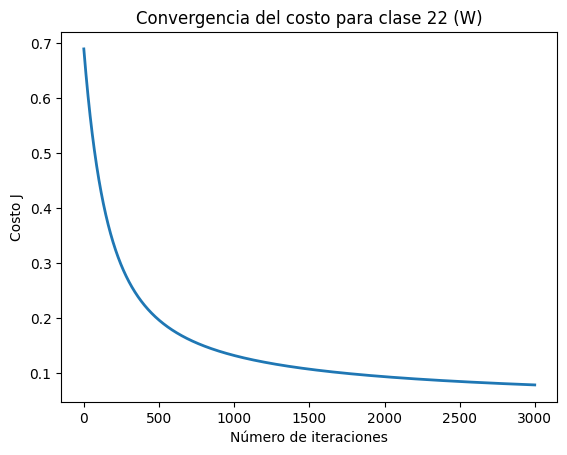

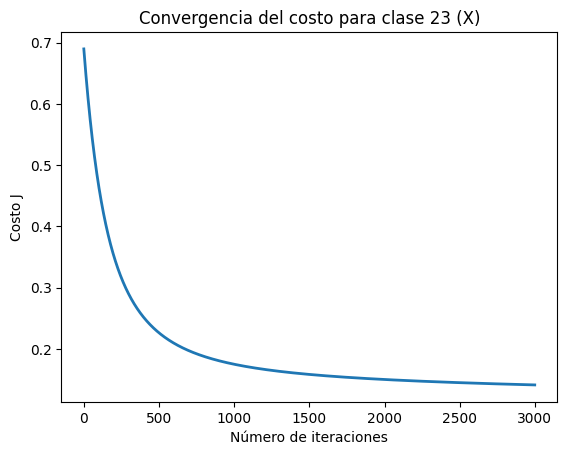

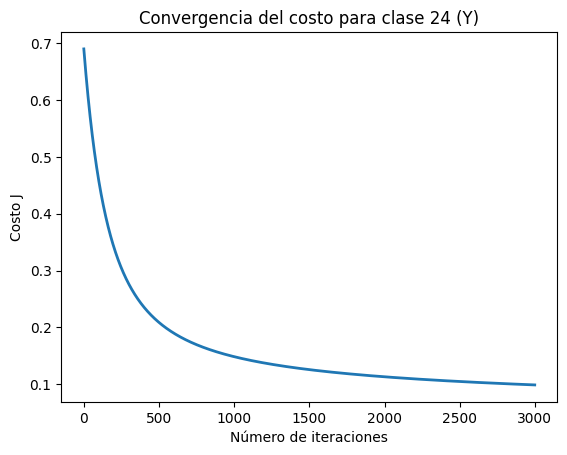

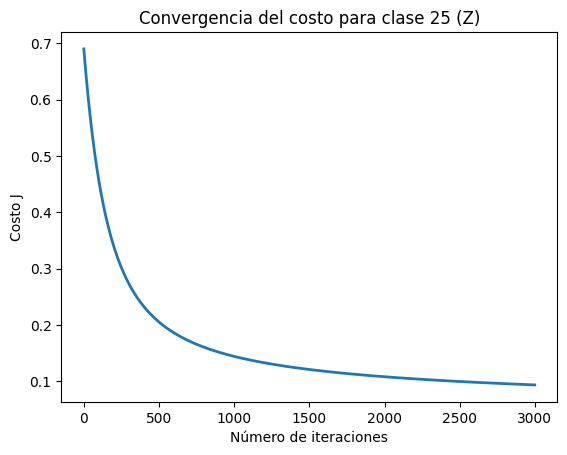

Exactitud en test set: 63.58%


In [33]:
import matplotlib.pyplot as plt
num_labels = 26
all_theta = OneVsAll(X_train, y_train, num_labels)

# Predicción
X_test_bias = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)
probs = sigmoid(X_test_bias.dot(all_theta.T))
y_pred = np.argmax(probs, axis=1)

# Accuracy
accuracy = np.mean(y_pred == y_test) * 100
print("Exactitud en test set: %.2f%%" % accuracy)

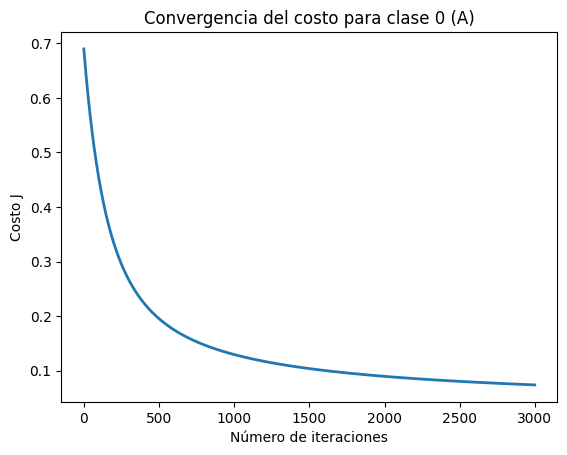

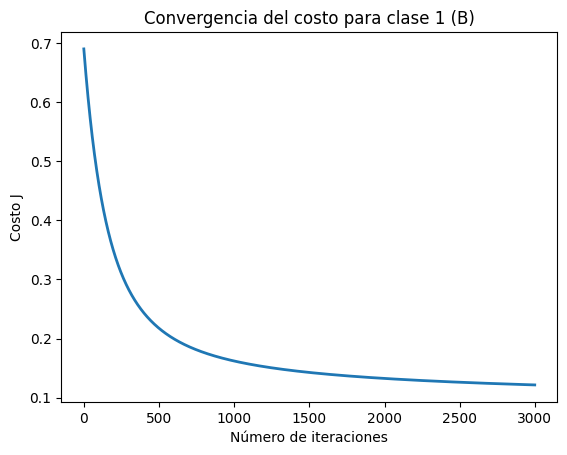

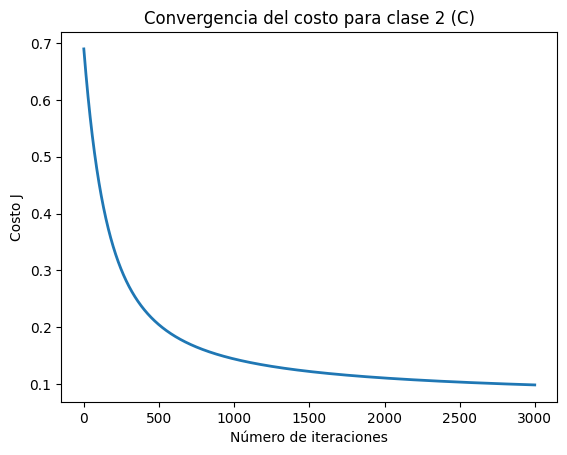

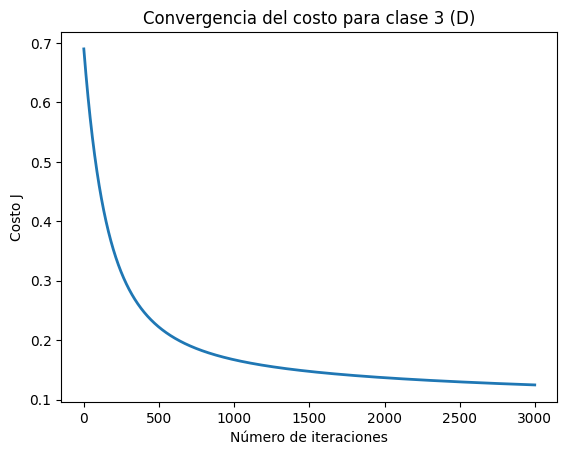

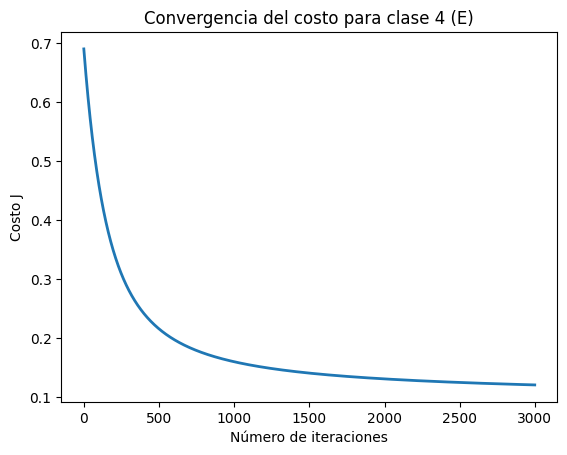

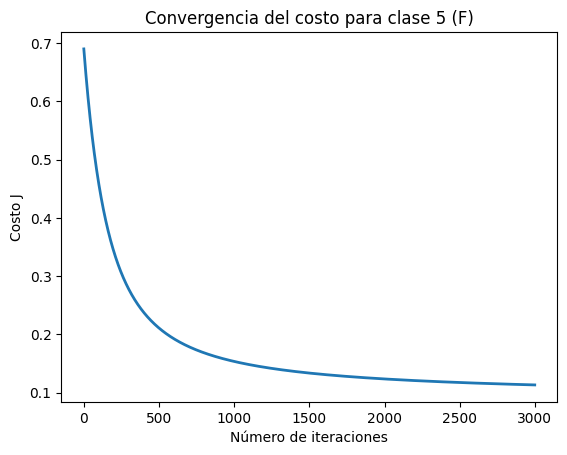

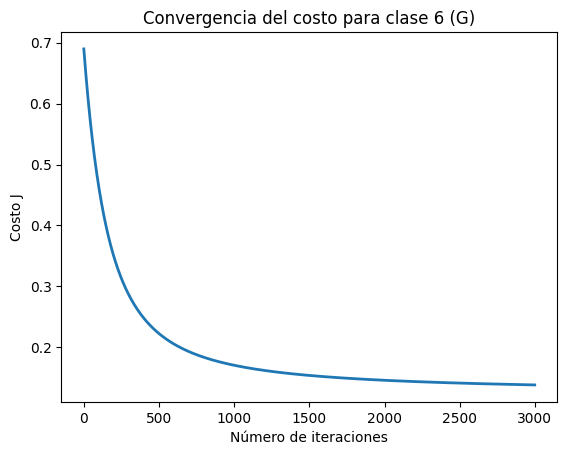

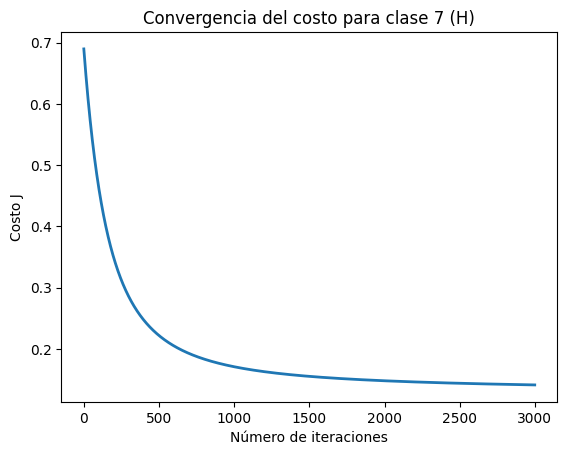

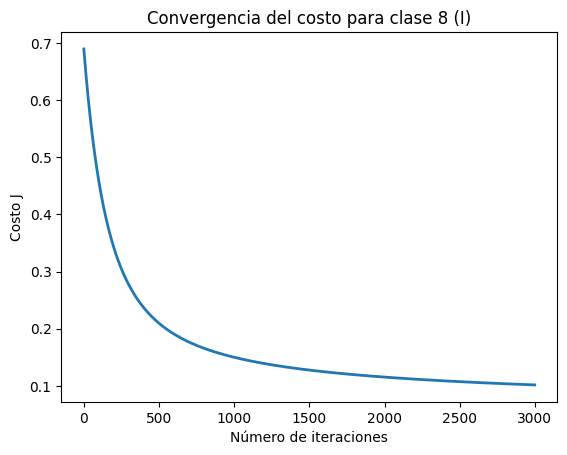

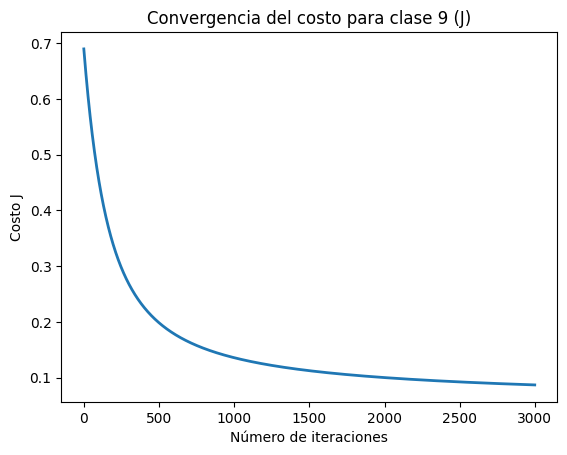

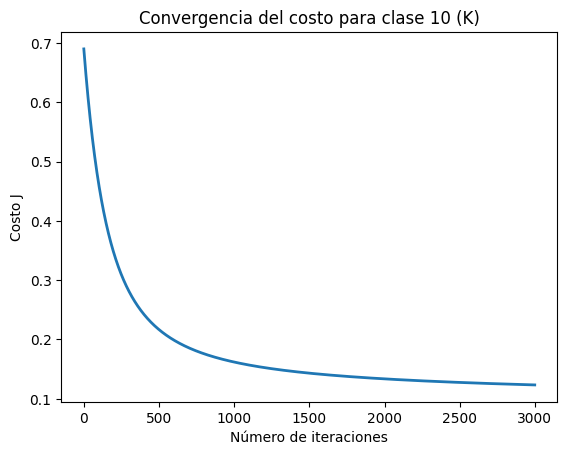

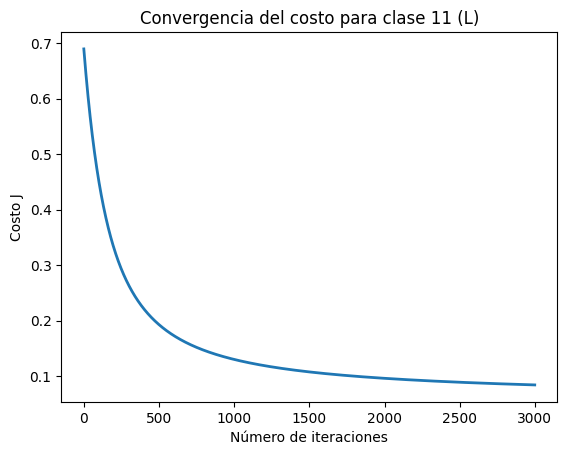

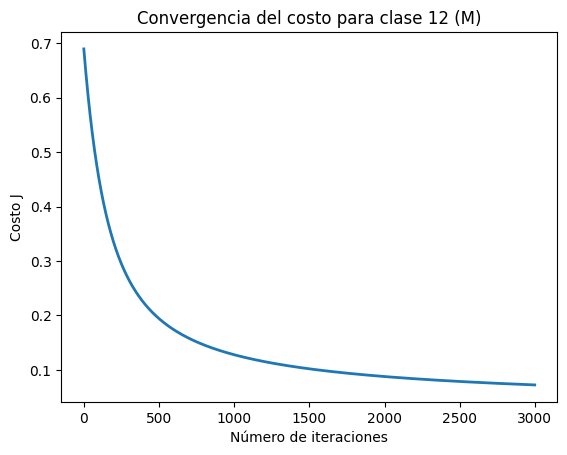

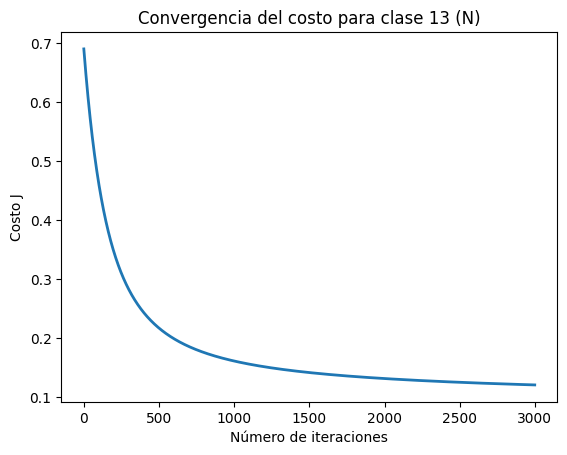

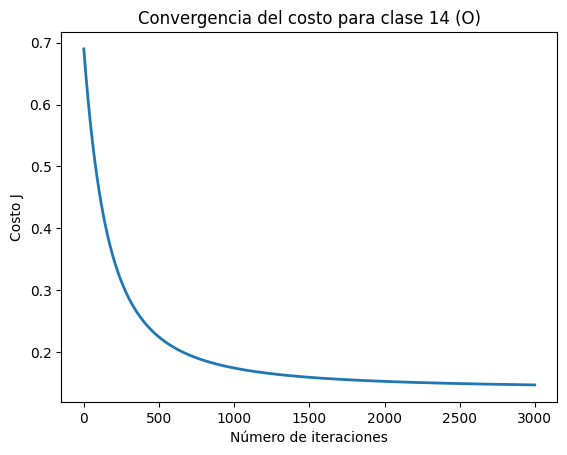

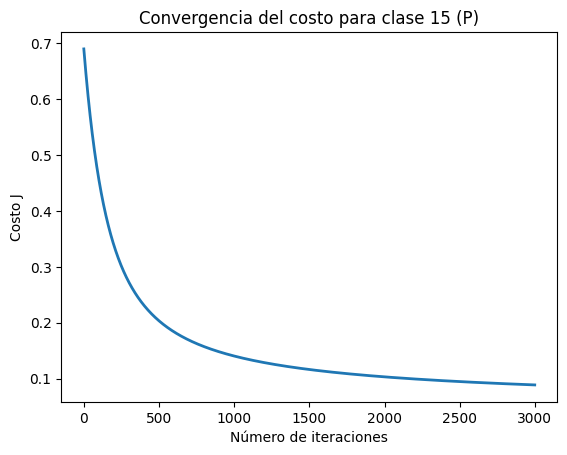

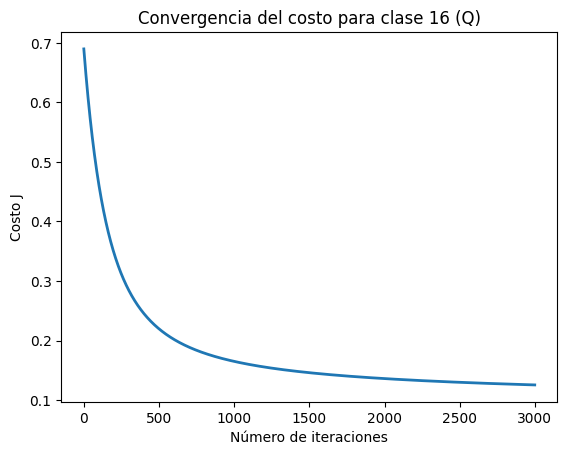

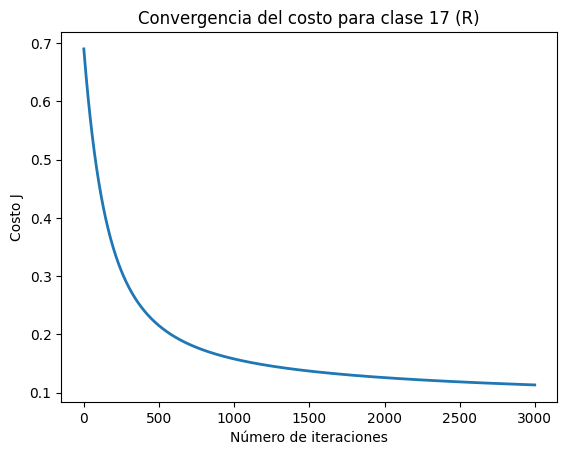

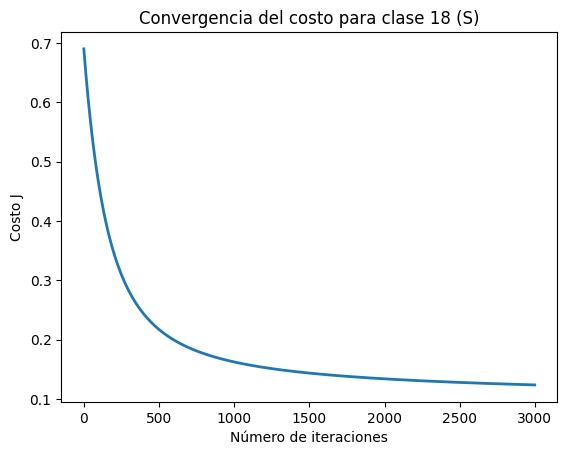

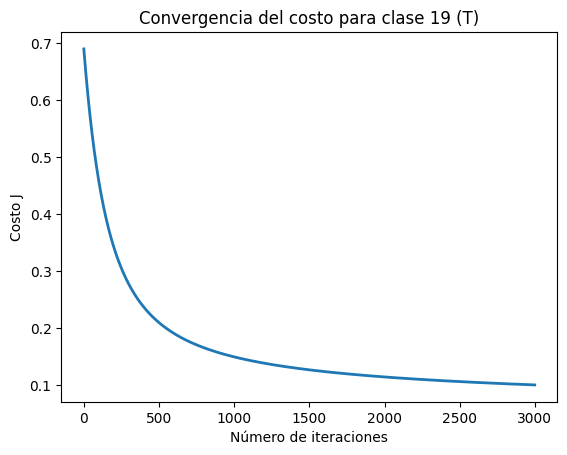

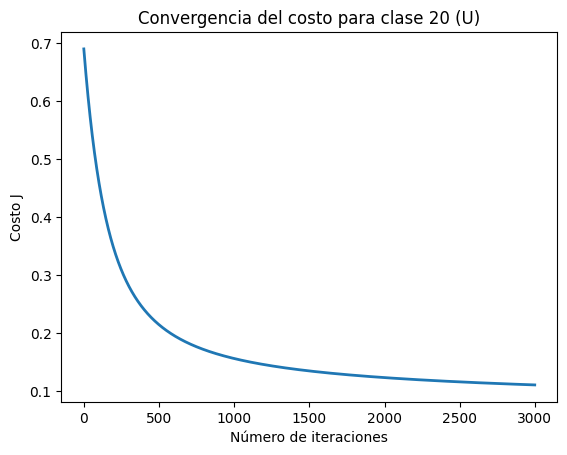

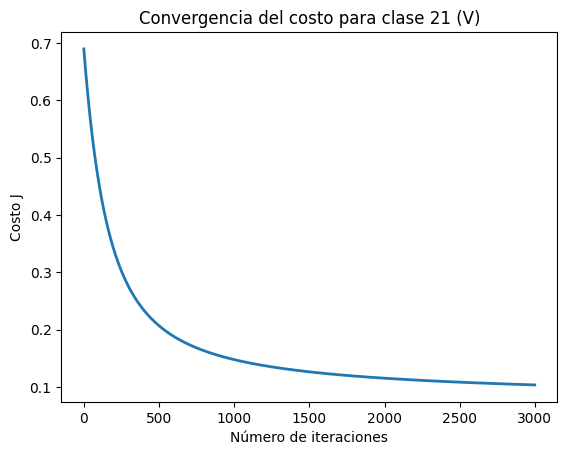

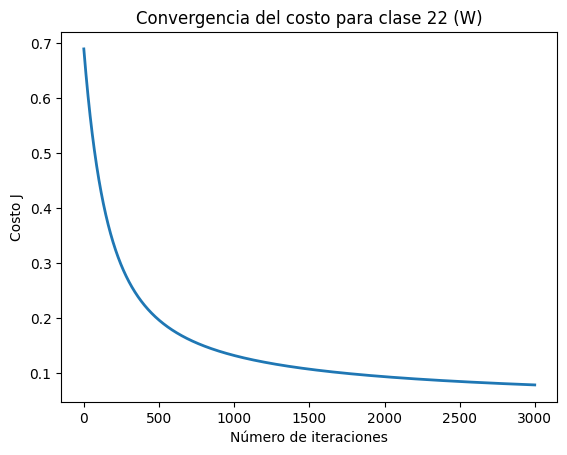

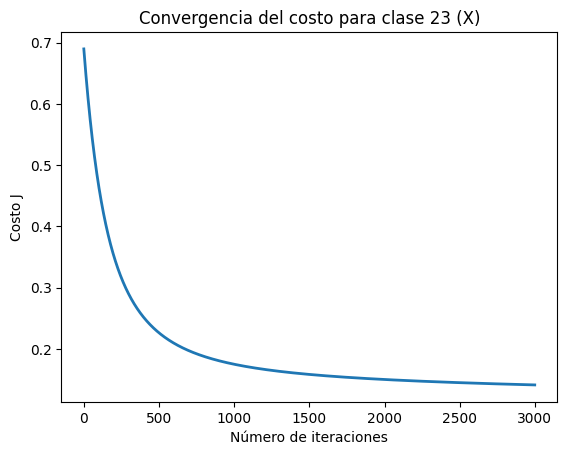

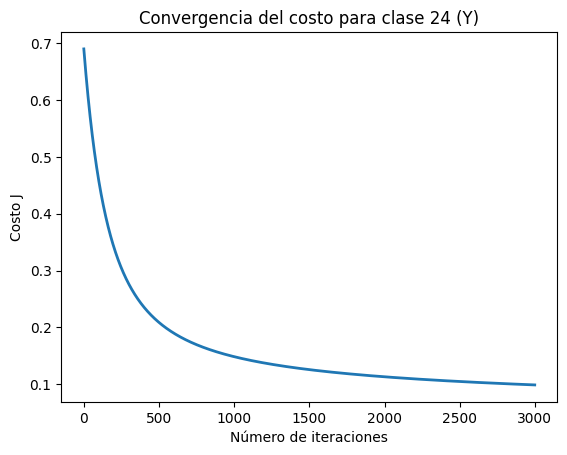

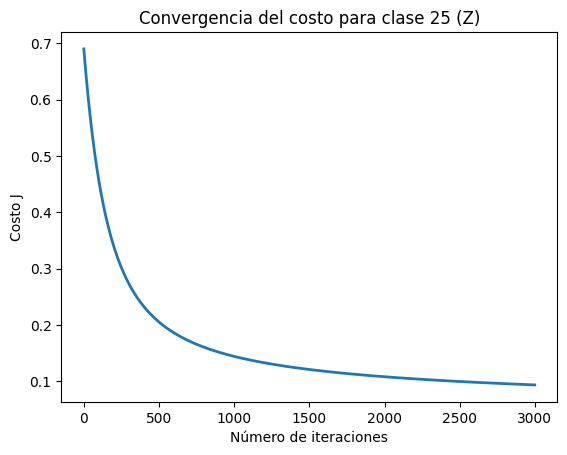

(26, 17)


In [34]:
lambda_ = 0.1
num_labels = 26

all_theta = OneVsAll(X_train, y_train, num_labels)   # entrenas con el 80% (X_train, y_train)
print(all_theta.shape)

In [35]:
print(all_theta)

[[-3.46403060e+00 -1.06646370e-01  3.90214033e-02  2.10604639e-01
   3.94006979e-02 -1.66862995e-01  1.89812132e-01 -4.21082790e-01
  -4.28511625e-01 -8.57482887e-01 -1.48434894e-01 -4.33647140e-01
   1.39728820e-01 -1.80601990e-01 -2.68121539e-01  3.72407884e-02
  -3.21402035e-01]
 [-3.23070324e+00 -6.27542229e-02 -2.36201794e-02 -1.20109262e-01
  -2.41102072e-01  2.70578007e-01  7.71380184e-02 -8.37331496e-02
   1.69233312e-01  7.15608262e-02  1.14090971e-02  3.17173482e-02
  -5.14329235e-01 -3.86638825e-02 -1.16814142e-01  5.96708417e-01
   4.05924488e-01]
 [-3.36057094e+00  8.33216560e-02  4.57385214e-02 -5.92068259e-02
  -9.35260582e-02 -5.95636173e-02 -2.09323744e-01  8.17203629e-02
   2.46922423e-01  2.41548881e-01  2.29435711e-01  8.31262900e-02
   8.61227157e-01 -3.89697126e-02  3.01498358e-01  3.97550331e-02
   2.17900757e-01]
 [-3.18736266e+00 -7.26936947e-02  2.52353270e-02 -8.89520757e-02
  -1.40813819e-01  2.10538440e-01  1.55366393e-01 -1.49265404e-01
   4.10319604e-01  

In [36]:
def predictOneVsAll(all_theta, X):
    """
    Devuelve un vector de predicciones para cada ejemplo en X.
    """
    m = X.shape[0]
    # Agregar columna de 1's (bias)
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    # Probabilidades de cada clase
    probs = sigmoid(X.dot(all_theta.T))
    # Tomar la clase con mayor probabilidad
    p = np.argmax(probs, axis=1)
    return p

In [37]:
# Predicciones sobre el set de test (20%)
y_pred = predictOneVsAll(all_theta, X_test)

# Calcular exactitud
accuracy = np.mean(y_pred == y_test) * 100
print("Exactitud en test set: %.2f%%" % accuracy)

# Ejemplo: mostrar primeras predicciones comparadas con letras originales
for i in range(10):
    print(f"Predicho: {le.classes_[y_pred[i]]}, Real: {le.classes_[y_test[i]]}")

Exactitud en test set: 63.58%
Predicho: R, Real: R
Predicho: M, Real: M
Predicho: B, Real: B
Predicho: P, Real: P
Predicho: J, Real: J
Predicho: L, Real: L
Predicho: P, Real: P
Predicho: B, Real: G
Predicho: Z, Real: Z
Predicho: V, Real: V


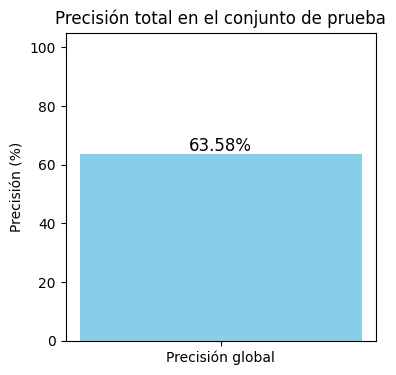

In [40]:
accuracy = np.mean(pred_test == y_test) * 100

plt.figure(figsize=(4,4))
plt.bar(["Precisión global"], [accuracy], color="skyblue")
plt.ylabel("Precisión (%)")
plt.ylim(0, 105)
plt.title("Precisión total en el conjunto de prueba")
plt.text(0, accuracy+1, f"{accuracy:.2f}%", ha="center", fontsize=12)
plt.show()

X_train.shape: (16000, 16)
X_test.shape : (4000, 16)
Precisión del conjunto de ENTRENAMIENTO: 63.67%
Precisión del conjunto de PRUEBA (20%): 63.58%
Predicciones (idx -100:): [ 8 24  0  1  2 11 12 20 20 21 12 15  9 16 17  2 19 19  7 16  9 23 16 20
  2  6  3  9 22  9  8 16  1 19 24  0 18 19 16 16 12 22 12  2 25 21 11  8
  6 22  2  0 10  5 25 18  8  4  5 15  4 22  2 17 21  1  6 11  5  8 20 19
 23  9 23 10  8 17  5  4 20 12 17  1 22  8 19 19 20  1 16  5  1 13  2 20
 12  3 16 20]
Reales       (idx -100:): [ 8 24 23 18  2 11 17 23 20 21 17 15  9  8  1  6 24 19 14 24  9 23 16 20
  2 19 17  9 21  9  9 24  1 19 18  0 18 19 18 16 12 22  7  2 25 21 11  8
  6 13  2  0 10  5 23 18  8  4  5  5  4 22  2 10 21  1  6 11  5 11 20 19
  8  9  7 10  1 17  5  4 20  6 17  1 22  8 19 19  7  1 16  5  9 13  2 20
 19 23 16 20]
Pred letras: ['I', 'Y', 'A', 'B', 'C', 'L', 'M', 'U', 'U', 'V', 'M', 'P', 'J', 'Q', 'R', 'C', 'T', 'T', 'H', 'Q', 'J', 'X', 'Q', 'U', 'C', 'G', 'D', 'J', 'W', 'J', 'I', 'Q', 'B', 'T', 'Y',

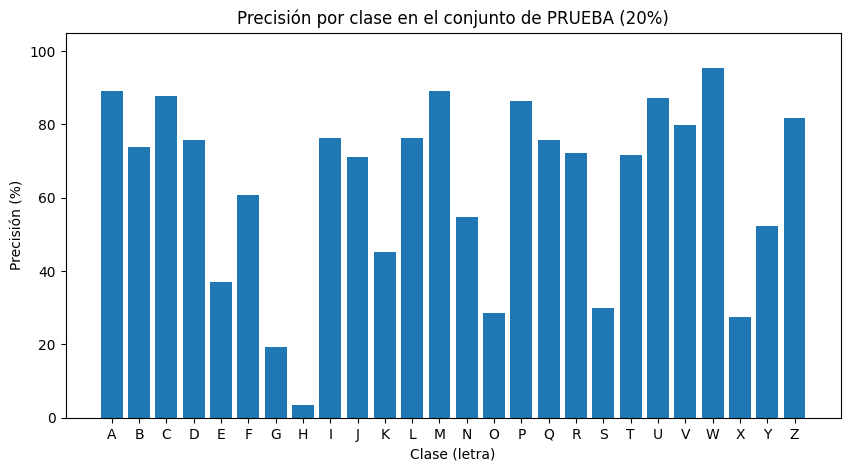

In [41]:
# Asumo que ya tienes: X_norm, y, le, X_train, X_test, y_train, y_test, all_theta
# y que definiste predictOneVsAll(...) y sigmoid(...)

import numpy as np
import matplotlib.pyplot as plt

# 1) Shapes de train/test
print("X_train.shape:", X_train.shape)   # (16000, 16)
print("X_test.shape :", X_test.shape)    # (4000, 16)

# 2) Precisión en entrenamiento (solo para monitoreo: ¡no confundir con performance real!)
pred_train = predictOneVsAll(all_theta, X_train)
print('Precisión del conjunto de ENTRENAMIENTO: {:.2f}%'.format(np.mean(pred_train == y_train) * 100))

# 3) Precisión en prueba
pred_test = predictOneVsAll(all_theta, X_test)
print('Precisión del conjunto de PRUEBA (20%): {:.2f}%'.format(np.mean(pred_test == y_test) * 100))

# 4) Mostrar los últimos 100 del TEST (no del full X)
ultimos_100_pred = pred_test[-100:]
ultimos_100_reales = y_test[-100:]
print("Predicciones (idx -100:):", ultimos_100_pred)
print("Reales       (idx -100:):", ultimos_100_reales)
# Si quieres ver letras:
print("Pred letras:", [le.classes_[k] for k in ultimos_100_pred])
print("Real letras:", [le.classes_[k] for k in ultimos_100_reales])

# 5) Precisión por clase (en el TEST)
num_labels = 26
precisiones = []
for c in range(num_labels):
    mask = (y_test == c)
    if np.any(mask):
        acc_c = np.mean(pred_test[mask] == c) * 100
    else:
        acc_c = np.nan
    precisiones.append(acc_c)

# 6) Gráfico de precisión por clase (A–Z)
plt.figure(figsize=(10, 5))
plt.bar(range(num_labels), precisiones, tick_label=list(le.classes_))
plt.ylabel('Precisión (%)')
plt.xlabel('Clase (letra)')
plt.title('Precisión por clase en el conjunto de PRUEBA (20%)')
plt.ylim(0, 105)
plt.show()